IPython magic command to render matplotlib plots.

In [1]:
%matplotlib inline

# MERFISH whole brain spatial transcriptomics (part 1)

The MERFISH data consists of 59 coronal sections (10 micron thick) covering the whole anterior to posterior extent of the brain (~200 micron apart) from a single adult male mouse. Each section is assayed using the MERSCOPE platform with a 500 gene panel designed to enable us to map cells to the whole mouse brain taxonomy.

The MERSCOPE platform uses combinatorial labeling, sequential imaging and error robust barcodes to obtain quantitative (counts) RNA-expression of 100s-1000s of genes. Each probe binds to a specific transcripts resulting in “dots” in the image. Cells are segmented using CellPose software based on DAPI/PolyT stains.

Gene expression data is stored either as individual sections or all sections in a single file. The puprose of this set of notebooks is to provide and overview of the data, the file organization and how to combine the data and metadata through example use cases.

You need to be connected to the internet to run this notebook and have run through the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html).

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [3]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20240831/manifest.json'

## Data overview

### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*.

Each cell is associated with a *brain section label*, *donor label*, *donor genotype* and *donor sex*. Each cell also has a set of x, y, z coordinates generated by rotating each section so that it is upright with midline approximatedly in the middle of the frame. The z coordinate takes into account the phyiscal spacing between each section.

Each cell is mapped to the whole mouse brain taxonomy using a hierachical correlation method, resulting in the assignment of a *cluster alias" and *average correlation score*.

In [4]:
cell = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='cell_metadata',
    dtype={"cell_label": str}
)
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))
cell.head(5)

cell_metadata.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 564M/564M [01:46<00:00, 5.32MMB/s]


Number of cells =  3938808


,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z
cell_label,,,,,,,,,,
1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,6.6
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4


We define a small helper fuction that uses pandas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [5]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c,len(grouped), members))

In [6]:
print_column_info(cell)

Number of unique brain_section_label = 59 
Number of unique cluster_alias = 5320 
Number of unique average_correlation_score = 3932069 
Number of unique feature_matrix_label = 1 ['C57BL6J-638850']
Number of unique donor_label = 1 ['C57BL6J-638850']
Number of unique donor_genotype = 1 ['wt/wt']
Number of unique donor_sex = 1 ['M']
Number of unique x = 3938808 
Number of unique y = 3938808 
Number of unique z = 59 


We can also bring in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [7]:
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)
cluster_details.head(5)

,neurotransmitter,class,subclass,supertype,cluster
cluster_alias,,,,,
1,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3
2,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3
3,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0322 L2 IT PPP-APr Glut_2
4,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0323 L2 IT PPP-APr Glut_2
5,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0325 L2 IT PPP-APr Glut_2


In [8]:
cluster_colors = abc_cache.get_metadata_dataframe(directory='WMB-taxonomy', file_name='cluster_to_cluster_annotation_membership_color')
cluster_colors.set_index('cluster_alias', inplace=True)
cluster_colors.head(5)

,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cluster_alias,,,,,
1,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F
2,#2B93DF,#FA0087,#0F6632,#266DFF,#CCA73D
3,#2B93DF,#FA0087,#0F6632,#002BCC,#99000D
4,#2B93DF,#FA0087,#0F6632,#002BCC,#5C8899
5,#2B93DF,#FA0087,#0F6632,#002BCC,#473D66


In [9]:
cell_extended = cell.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias')
cell_extended.head(5)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cell_label,,,,,,,,,,,,,,,,,,,,
1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,6.6,,04 DG-IMN Glut,038 DG-PIR Ex IMN,0141 DG-PIR Ex IMN_2,0515 DG-PIR Ex IMN_2,#666666,#16f2f2,#3D53CC,#CC7A3D,#73FFBF
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63


In [10]:
print_column_info(cell_extended)

Number of unique brain_section_label = 59 
Number of unique cluster_alias = 5320 
Number of unique average_correlation_score = 3932069 
Number of unique feature_matrix_label = 1 ['C57BL6J-638850']
Number of unique donor_label = 1 ['C57BL6J-638850']
Number of unique donor_genotype = 1 ['wt/wt']
Number of unique donor_sex = 1 ['M']
Number of unique x = 3938808 
Number of unique y = 3938808 
Number of unique z = 59 
Number of unique neurotransmitter = 10 ['', 'Chol', 'Dopa', 'GABA', 'GABA-Glyc', 'Glut', 'Glut-GABA', 'Hist', 'Nora', 'Sero']
Number of unique class = 34 
Number of unique subclass = 338 
Number of unique supertype = 1201 
Number of unique cluster = 5320 
Number of unique neurotransmitter_color = 10 ['#03EDFF', '#0a9964', '#2B93DF', '#533691', '#666666', '#73E785', '#820e57', '#FF3358', '#fcf04b', '#ff7621']
Number of unique class_color = 34 
Number of unique subclass_color = 338 
Number of unique supertype_color = 1201 
Number of unique cluster_color = 5296 


The ``cell_extended`` dataframe created above is available in the cache as ``cell_metadata_with_cluster_annotation``.

### Gene panel

A 500 gene panel was selected to enable faciliate the mapping to the whole mouse brain taxonomy. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time. The expression matrices also includes data for 50 "blanks" codewords in the spatial transcriptomic codebook that are not associated with any gene. They are included to measure the false discovery rate of gene detection.

Each row of the gene dataframe has Ensembl gene identifier, the identifier of the transcript the probe targets, a gene symbol and name.

In [11]:
gene = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='gene')
gene.set_index('gene_identifier', inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

gene.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48.4k/48.4k [00:00<00:00, 532kMB/s]

Number of genes =  550


,gene_symbol,transcript_identifier,name,mapped_ncbi_identifier
gene_identifier,,,,
ENSMUSG00000026778,Prkcq,ENSMUST00000028118,"protein kinase C, theta",NCBIGene:18761
ENSMUSG00000026837,Col5a1,ENSMUST00000028280,"collagen, type V, alpha 1",NCBIGene:12831
ENSMUSG00000001985,Grik3,ENSMUST00000030676,"glutamate receptor, ionotropic, kainate 3",NCBIGene:14807
ENSMUSG00000039323,Igfbp2,ENSMUST00000047328,insulin-like growth factor binding protein 2,NCBIGene:16008
ENSMUSG00000048387,Osr1,ENSMUST00000057021,odd-skipped related transcription factor 1,NCBIGene:23967


### Gene expression matrix

Expression values for all sections are stored in an anndata h5ad format with minimal metadata. There are two h5ad files one storing the raw counts and the other log normalization of it. In this next section, we provide example code on how to open the file and connect with the rich cell level metadata discussed above.


In [12]:
abc_cache.list_data_files('MERFISH-C57BL6J-638850')

['C57BL6J-638850/log2', 'C57BL6J-638850/raw']

In [13]:
file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850', file_name='C57BL6J-638850/log2')
print(file)

C57BL6J-638850-log2.h5ad: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7.63G/7.63G [04:53<00:00, 26.0MMB/s]

/Users/chris.morrison/src/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad


We use the anndata's *read_h5ad* function to open the package for the log2 normalization file. The "backed='r'" makes use of the lazy loading functionality to only load required data. By default, anndata will load the entire expression matrix in memory.

In [14]:
adata = anndata.read_h5ad(file, backed='r')
print(adata)

AnnData object with n_obs × n_vars = 4334174 × 550 backed at '/Users/chris.morrison/src/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad'
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src'


Genes are represented as "variables". For this data, the var dataframe is indexed by the Ensembl gene identifier with one metadata column gene symbol

In [15]:
print("Number of genes = ", len(adata.var))
adata.var.index[0:5]

Number of genes =  550


Index(['ENSMUSG00000026778', 'ENSMUSG00000026837', 'ENSMUSG00000001985',
       'ENSMUSG00000039323', 'ENSMUSG00000048387'],
      dtype='object', name='gene_identifier')

We define a small helper function *plot section* to visualize the cells in anatomical context colorized by: neurotransmitter identity, cell types division, class and subclass.

In [16]:
def plot_section(xx, yy, cc = None, val = None, fig_width = 8, fig_height = 8, cmap = None):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return fig, ax

Let pick one section "C57BL6J-638850.38" for visualization.

In [17]:
pred = (cell_extended['brain_section_label'] == 'C57BL6J-638850.38')
section = cell_extended[pred]
print("Number of cells in section:",len(section))

Number of cells in section: 120186


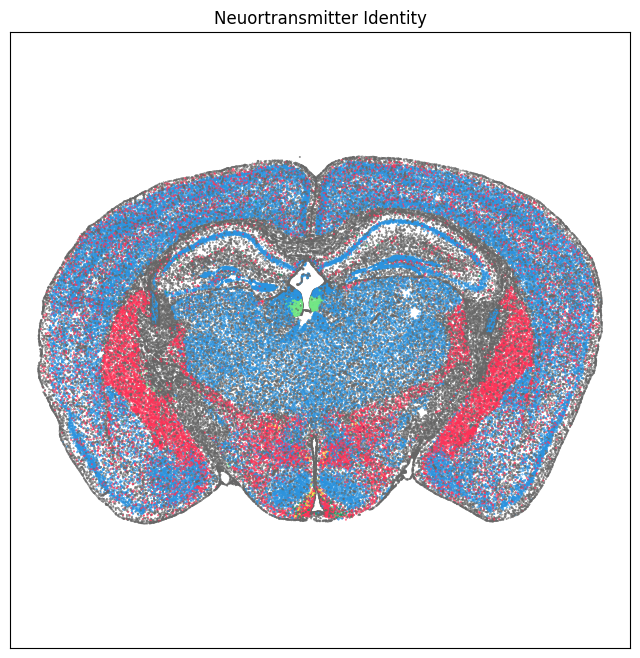

In [18]:
fig, ax = plot_section(section['x'], section['y'], section['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter Identity")

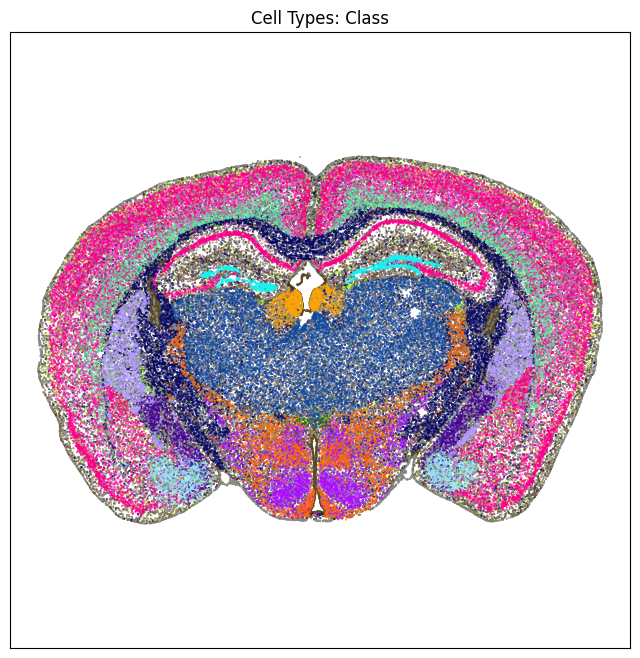

In [19]:
fig, ax = plot_section(section['x'], section['y'], section['class_color'])
res = ax.set_title("Cell Types: Class")

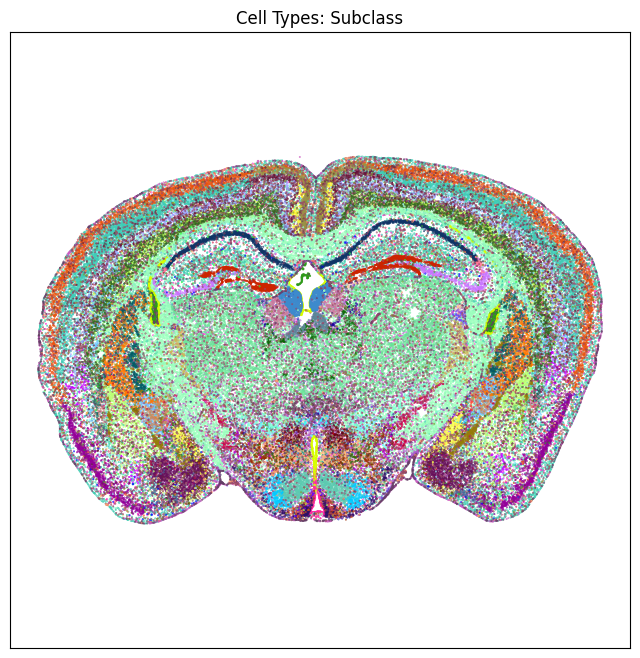

In [20]:
fig, ax = plot_section(section['x'], section['y'], section['subclass_color'])
res = ax.set_title("Cell Types: Subclass")

## Example use cases

In this section, we explore the same two use cases as with the 10x data. The first example looks at the expression of nine canonical neurotransmitter transporter genes and the second the expression of gene Tac2. To support these use cases, we will create a smaller submatrix (all cells and 10 genes) that read it into memory. *Note this operation takes around 10 seconds*.

In [21]:
ntgenes = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4']
exgenes = ['Tac2']
gnames = ntgenes + exgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

,gene_symbol,transcript_identifier
gene_identifier,,
ENSMUSG00000030500,Slc17a6,ENSMUST00000032710
ENSMUSG00000037771,Slc32a1,ENSMUST00000045738
ENSMUSG00000025400,Tac2,ENSMUST00000026466
ENSMUSG00000039728,Slc6a5,ENSMUST00000056442
ENSMUSG00000070570,Slc17a7,ENSMUST00000085374
ENSMUSG00000019935,Slc17a8,ENSMUST00000020102
ENSMUSG00000021609,Slc6a3,ENSMUST00000022100
ENSMUSG00000020838,Slc6a4,ENSMUST00000021195


In [22]:
start = time.process_time()
asubset = adata[:, gene_filtered.index].to_memory()
print("time taken: ", time.process_time() - start)
print(asubset)

time taken:  7.14711299999999
AnnData object with n_obs × n_vars = 4334174 × 8
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src'


We define two helper functions to (1) *create_expression_dataframe*: create joined gene expression and cell metadata dataframe based for a set of input genes and (2) *aggregate_by_metadata* which computes the average expression for each term in a given category.

In [23]:
def create_expression_dataframe(ad, gf):
    gdata = ad[:, gf.index].to_df()
    gdata.columns = gf.gene_symbol
    joined = section.join(gdata)
    return joined

In [24]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

### Expression of canonical neurotransmitter transporter genes

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of cells in the 'C57BL6J-638850.40' section and expression of the 9 solute carrier family genes. We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group and visualized as a colorized table. The results are similar of the 10x data restricted to cells from the thalamus.

In [25]:
def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap = plt.cm.magma_r):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=5)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

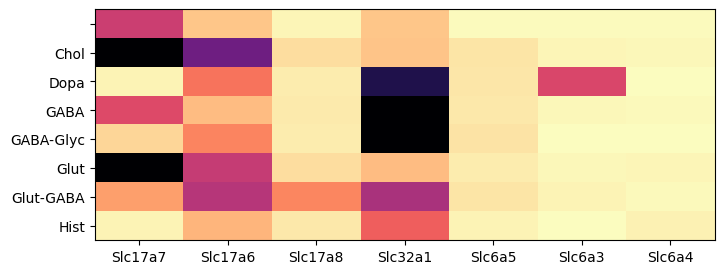

In [26]:
pred = [x in ntgenes for x in asubset.var.gene_symbol]
gf = asubset.var[pred]

ntexp = create_expression_dataframe(asubset, gf)
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
agg = agg[ntgenes]
im = plot_heatmap(agg, 8, 3)

The expression data can also be visualized as scatter point in anatomical context. Gene Slc17a7 is highly enriched in the cortex , hippocampus, medial habenula with some expression in the thalamus. On the other hand gene Slc32a1 is enriched in the striatum with sparse expression on the cortical plate.

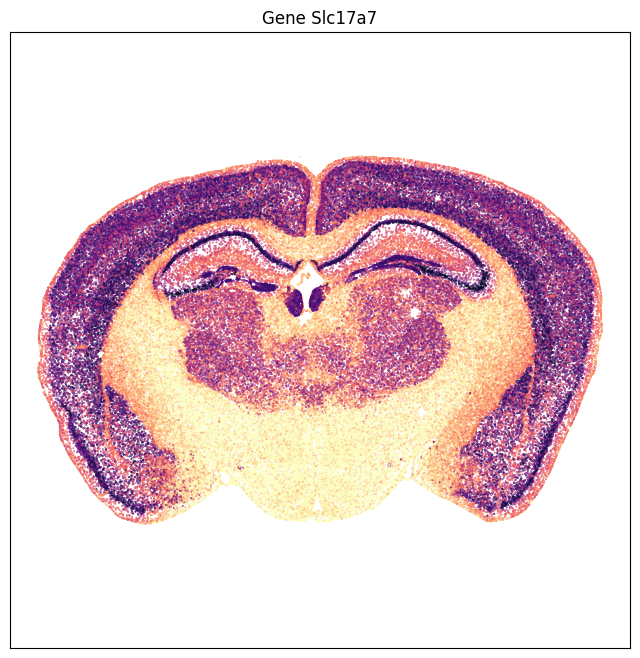

In [27]:
fig, ax = plot_section(ntexp['x'], ntexp['y'], val=ntexp['Slc17a7'], cmap=plt.cm.magma_r)
res = ax.set_title('Gene Slc17a7')

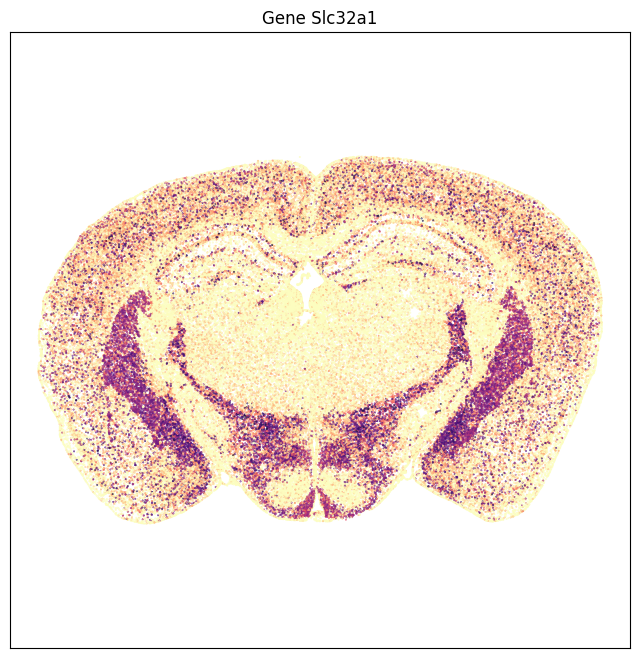

In [28]:
fig, ax = plot_section(ntexp['x'], ntexp['y'], val=ntexp['Slc32a1'], cmap=plt.cm.magma_r)
res = ax.set_title('Gene Slc32a1')

### Expression of Tachykinin 2 (Tac2) in the whole brain

In mice, the tachykinin 2 (Tac2) gene encodes neuropeptide called neurokinin B (NkB). Tac2 is produced by neurons in specific regions of the brain know to be invovled in emotion and social behavior. Based on [ISH data](https://mouse.brain-map.org/experiment/siv?id=77279001&imageId=77284584&initImage=ish&coordSystem=pixel&x=5384.5&y=3832.5&z=3) from the Allen Mouse Brain Atlas, Tac 2 is sparsely expressed in the mouse isocortex and densely enriched is specific subcortical regions such the medial habenula (MH), the amygdala and hypothalamus.

In this example, we create a dataframe comprising of cells in section 'C57BL6J-638850.40' and expression values of Tac2 in those cells.

In [29]:
gf = asubset.var[asubset.var.gene_symbol == 'Tac2']
tac2 = create_expression_dataframe(asubset, gf)

Grouping cells by neurotransmitter identites and computing the mean expression in each group, we can observed that Tac2 gene is highly enriched in cholinergic cell types with some expression in Glut-GABA types.

/var/folders/kc/7glrmt5n67x16yj_tg86t49c0000gp/T/ipykernel_73966/2280752953.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0], ascending=False)


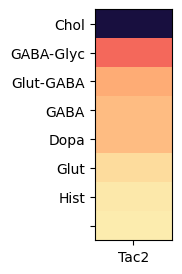

In [30]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'neurotransmitter', True).head(8)
im = plot_heatmap(agg, 1, 3)

Grouping cells by cell types class, shows that Tac2 is enriched in class "16 MH-LH Glut" with cells restricted to the medial (MH) and lateral (LH) habenula and a mixture of glutamatergic and cholinergic types.

/var/folders/kc/7glrmt5n67x16yj_tg86t49c0000gp/T/ipykernel_73966/2280752953.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0], ascending=False)


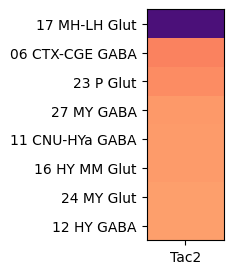

In [31]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'class', True).head(8)
im = plot_heatmap(agg, 1, 3)

At the next level, grouping by subclass, shows Tac2 is enriched in sublcasses with specificity to the medial habenula (MH), bed muclei of the stria terminalis (BST) and main olfactory blub (MOB).

/var/folders/kc/7glrmt5n67x16yj_tg86t49c0000gp/T/ipykernel_73966/2280752953.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0], ascending=False)


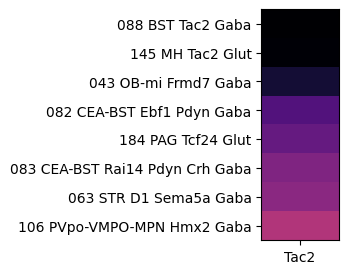

In [32]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'subclass', True).head(8)
im = plot_heatmap(agg, 1, 3)

Plotting Tac2 expression in anatomical coordinates results in a image that is comparable to the ISH image data showing enriched expression in the medial habenula, amydala and hypothalamus and sparse expression in the cortex.

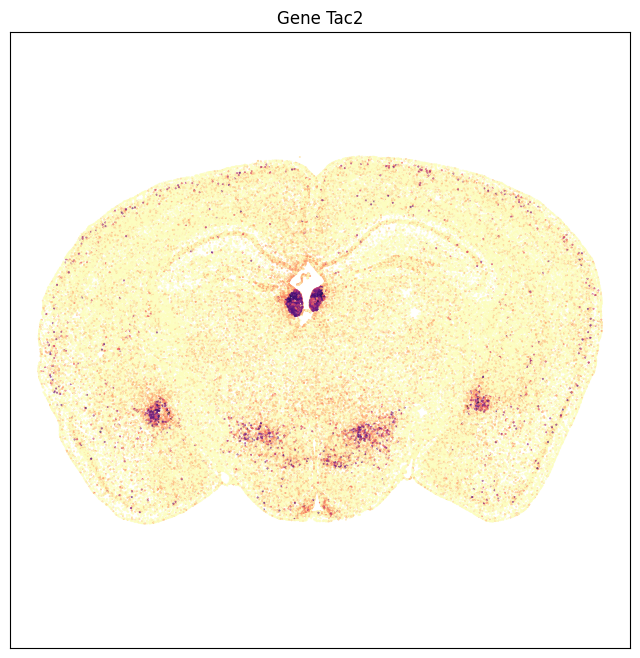

In [33]:
fig,ax = plot_section(tac2['x'], tac2['y'], val=tac2['Tac2'], cmap=plt.cm.magma_r)
res = ax.set_title('Gene Tac2')

Close h5ad file and clean up

In [34]:
adata.file.close()
del adata